# Neural Network classification



The CIFAR-10 dataset consists of 60.000 32x32 colour images in 10 classes, with 6.000 images per class. There are 50.000 training images and 10.000 test images.

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

In [2]:
# Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Preprocessing step


In [3]:
# Transformations applied to images
transformations = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))
    ])

### Import dataframe

In [4]:
# Train
train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transformations)
trainloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True, num_workers=2)

# Test
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transformations)
testloader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:04<00:00, 41.2MB/s]


## Model Definition

In [5]:
# Neural Network model

class Net(nn.Module):

    def __init__(self):

        super().__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [6]:
net = Net()
_ = net.to(device)

## Model Training

In [7]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [8]:
# Model training
for epoch in range(5):

  running_loss = 0.0
  for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1}", unit="batch"):

      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      running_loss += loss.item()

  print(f"Epoch {epoch+1} - Loss: {running_loss/len(trainloader):.3f}")

Epoch 1: 100%|██████████| 1563/1563 [00:17<00:00, 91.21batch/s]


Epoch 1 - Loss: 2.001


Epoch 2: 100%|██████████| 1563/1563 [00:17<00:00, 89.94batch/s] 


Epoch 2 - Loss: 1.570


Epoch 3: 100%|██████████| 1563/1563 [00:16<00:00, 96.76batch/s] 


Epoch 3 - Loss: 1.389


Epoch 4: 100%|██████████| 1563/1563 [00:16<00:00, 96.84batch/s]


Epoch 4 - Loss: 1.265


Epoch 5: 100%|██████████| 1563/1563 [00:17<00:00, 91.80batch/s]

Epoch 5 - Loss: 1.150


In [9]:
# Save (and load) trained model
PATH = './NN.pth'
torch.save(net.state_dict(), PATH)
# net.load_state_dict(torch.load(PATH, map_location=device))

## Model Performance

In [10]:
# Test results
real = []; pred = []; prob = []

for data in testloader:

  image, label = data
  image = image.to(device)
  output = net(image)

  pred.append(output.argmax(axis=1).detach().cpu().numpy())
  prob.append(output.max(axis=1)[0].detach().cpu().numpy())
  real.append(label.detach().cpu().numpy())

pred = np.concatenate(pred)
real = np.concatenate(real)
prob = np.concatenate(prob)

test_results = pd.DataFrame(np.stack([real, pred, prob], axis=1), columns=['real', 'pred', 'prob'])

In [11]:
# Classification report
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(classification_report(test_results['real'].map({i:c for i, c in enumerate(classes)}),
                            test_results['pred'].map({i:c for i, c in enumerate(classes)})))

              precision    recall  f1-score   support

        bird       0.49      0.42      0.45      1000
         car       0.71      0.74      0.72      1000
         cat       0.40      0.43      0.42      1000
        deer       0.54      0.49      0.51      1000
         dog       0.52      0.54      0.53      1000
        frog       0.62      0.76      0.68      1000
       horse       0.73      0.62      0.67      1000
       plane       0.64      0.67      0.66      1000
        ship       0.69      0.74      0.71      1000
       truck       0.69      0.61      0.65      1000

    accuracy                           0.60     10000
   macro avg       0.60      0.60      0.60     10000
weighted avg       0.60      0.60      0.60     10000



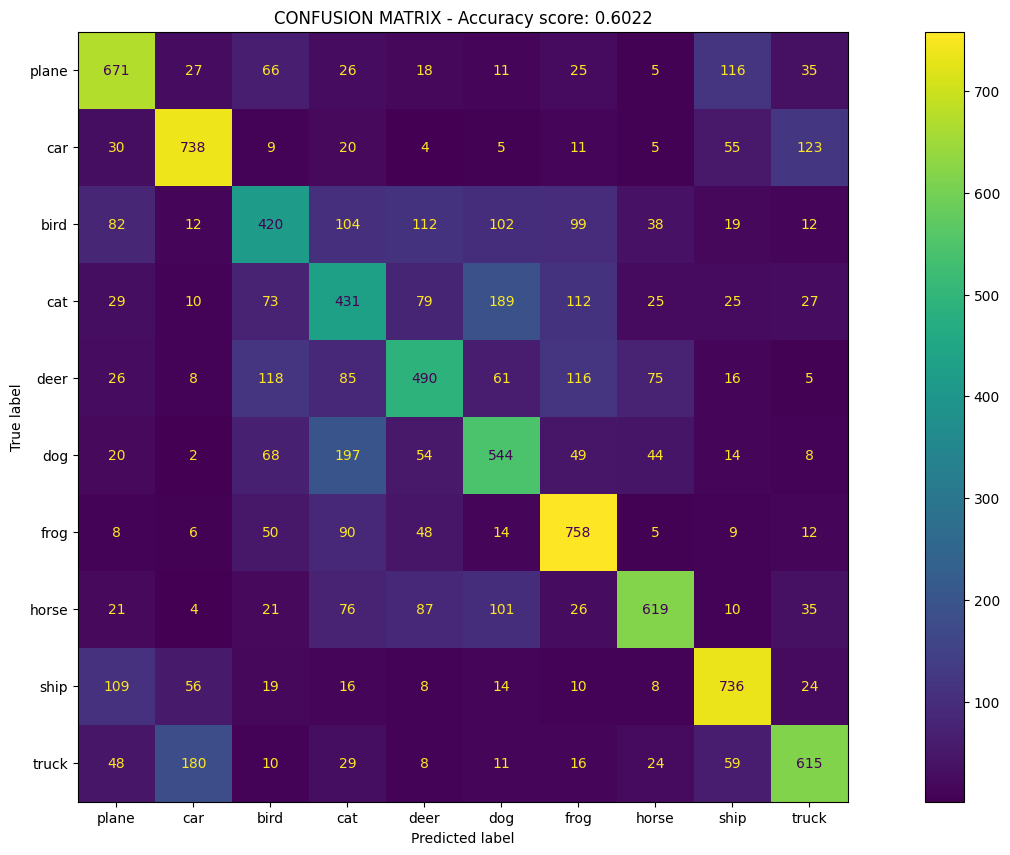

In [12]:
# Confusion matrix
fig, ax = plt.subplots(1, figsize=(20, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(test_results['real'], test_results['pred']),
                              display_labels=classes)
disp.plot(ax=ax)
plt.title('CONFUSION MATRIX - Accuracy score: {:.4f}'.format(accuracy_score(test_results['real'], test_results['pred'])))
plt.show()